In [1]:
import os
import numpy as np
import glob
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [2]:
root_dir = 'Label'

In [3]:
label_lst = os.listdir(root_dir)[0]
label_lst

'Bearing1_1.npy'

In [4]:
freq = 25600

In [5]:
class FeatDataset(Dataset):
    def __init__(self, label_dir='Label', data_dir='Learning_set', mode=None, data_set_num=0):
        super(FeatDataset, self).__init__()

        self.label_dir = label_dir
        self.data_dir = data_dir
        self.mode = mode
        self.data_set_num = data_set_num

        self.data_files_dir_lst = self.process_feats()
        self.t_label = self.process_labels()

    def process_labels(self):
        t_label = []
        label_lst = os.listdir(self.label_dir)
        num_label = []

        for i, label_file in enumerate(label_lst):
            label = np.load(os.path.join(self.label_dir, label_file))
            num_label.append(label.shape[0])

            if self.mode and i == self.data_set_num:
                break
        
        for num in num_label:
            t = np.arange(0, num) / num
            t = t.tolist()
            t.reverse()
            t_label.extend(t)
        
        return t_label

    def process_feats(self):
        data_files_lst = os.listdir(self.data_dir)

        data_files_dir_lst = []
        for i, data_dir in enumerate(data_files_lst):
            data_dir_lst = glob.glob(os.path.join(self.data_dir, data_dir, 'acc_*.csv'))
            data_files_dir_lst.extend(data_dir_lst)

            if self.mode and i == self.data_set_num:
                break

        return data_files_dir_lst
    
    
    def __len__(self):
        return len(self.data_files_dir_lst)
    

    def __getitem__(self, index):

        self.data = self.data_files_dir_lst[index]
        self.label = self.t_label[index]

        df = pd.read_csv(self.data, sep=',', header=None)
        signal = df.iloc[:, -2:].values
        signal = np.transpose(signal, (1, 0))

        label = torch.from_numpy(np.asarray(self.label)).type(torch.float32)
        feats = torch.from_numpy(signal).type(torch.float32)

        return feats, label




In [6]:
train_dataset = FeatDataset(mode=True)

In [7]:
# Define Model
class CNN(nn.Module):
    def __init__(self, data_shape, in_channel, out_channel):
        super(CNN, self).__init__()

        self.data_shape = data_shape
        self.conv1 = nn.Conv1d(in_channel, out_channel, kernel_size=4, stride=2)
        self.map1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(out_channel, out_channel, kernel_size=2)
        self.map2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.get_linear_size()

        self.fc1 = nn.Linear(self.linear_in_size, 100)
        self.fc2 = nn.Linear(100, 1)
    
    def get_linear_size(self):
        x = torch.randn(self.data_shape)
        x = self.conv1(x)
        x = F.relu(self.map1(x))
        x = self.conv2(x)
        x = F.relu(self.map2(x))
        self.linear_in_size = x.numel()
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.map1(x))
        x = F.relu(self.map2(self.conv2(x)))

        x = x.view(-1, self.linear_in_size)
        x = self.fc1(x)
        x = F.sigmoid(self.fc2(x))
        return x

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN((1, 2, 2560), 2, 128).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
loss = nn.SmoothL1Loss()
train_loader = DataLoader(train_dataset, 512)

In [9]:
for epoch in range(50):
    train_loss_lst = []
    for feats, label in train_loader:
        feats = feats.to(device)
        label = label.unsqueeze(dim=1).to(device)

        pred = model(feats)
        train_loss = loss(pred, label)

        optim.zero_grad()
        train_loss.backward()
        optim.step()

        train_loss_lst.append(train_loss.item())
    
    avg_loss = sum(train_loss_lst) / len(train_loss_lst)

    print('epoch: {}, train_loss: {:.4f}'.format(epoch, avg_loss))

torch.save(model.state_dict(), 'rul_model.pth')


epoch: 0, train_loss: 0.1932
epoch: 1, train_loss: 0.1828
epoch: 2, train_loss: 0.1127
epoch: 3, train_loss: 0.0319
epoch: 4, train_loss: 0.0690
epoch: 5, train_loss: 0.0334
epoch: 6, train_loss: 0.0192
epoch: 7, train_loss: 0.0061
epoch: 8, train_loss: 0.0077
epoch: 9, train_loss: 0.0068
epoch: 10, train_loss: 0.0052
epoch: 11, train_loss: 0.0044
epoch: 12, train_loss: 0.0038
epoch: 13, train_loss: 0.0039
epoch: 14, train_loss: 0.0038
epoch: 15, train_loss: 0.0037
epoch: 16, train_loss: 0.0035
epoch: 17, train_loss: 0.0033
epoch: 18, train_loss: 0.0032
epoch: 19, train_loss: 0.0031
epoch: 20, train_loss: 0.0029
epoch: 21, train_loss: 0.0027
epoch: 22, train_loss: 0.0026
epoch: 23, train_loss: 0.0024
epoch: 24, train_loss: 0.0022
epoch: 25, train_loss: 0.0020
epoch: 26, train_loss: 0.0019
epoch: 27, train_loss: 0.0017
epoch: 28, train_loss: 0.0016
epoch: 29, train_loss: 0.0015
epoch: 30, train_loss: 0.0014
epoch: 31, train_loss: 0.0013
epoch: 32, train_loss: 0.0012
epoch: 33, train_los

In [10]:
model.load_state_dict(torch.load('rul_model.pth'))

C:\Users\wangj\AppData\Local\Temp\ipykernel_11840\2164002088.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('rul_model.pth'))


<All keys matched successfully>

In [11]:
test_data_dir = os.listdir('Test_set')
test_data_dirs = glob.glob(os.path.join('Test_set', test_data_dir[0], 'acc_*.csv'))
out = []
for test_data_dir in test_data_dirs:
    data = pd.read_csv(test_data_dir, sep=',', header=None)
    signal = data.iloc[:, -2:].values
    signal = np.transpose(signal, (1, 0))
    signal = np.expand_dims(signal, axis=0)
    signal = torch.from_numpy(signal).type(torch.float32).to(device)

    pred = model(signal)

    out.extend(pred.detach().cpu().numpy())

In [12]:
import matplotlib.pyplot as plt

In [13]:
labels_num = len(os.listdir('Test_set/Bearing1_3'))
labels_num

1802

In [14]:
labels = np.arange(0, labels_num).tolist()
labels.reverse()
labels = [x/len(labels) for x in labels]

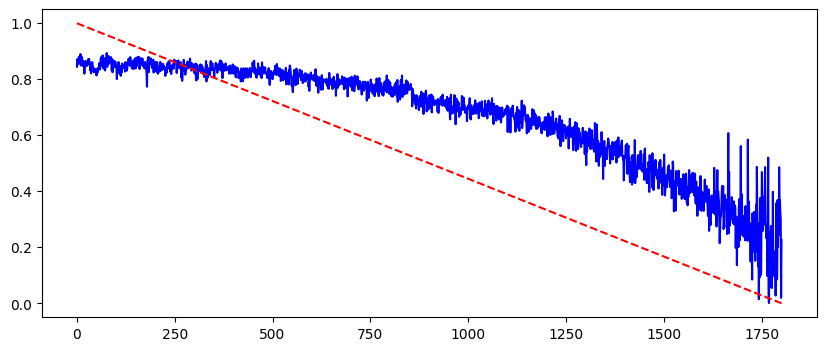

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(out, c='blue')
plt.plot(labels, c='red', linestyle='--')